In [1]:
import keras
import tensorflow as tf
import numpy as np
from PIL import Image

Using TensorFlow backend.


(658, 288, 352, 3)
(658,)
1


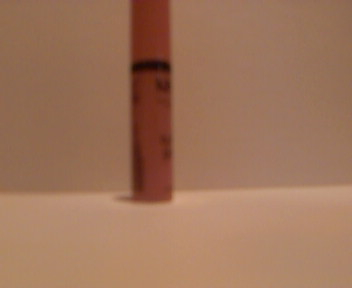

In [2]:
# Note: data isn't in the repository

# loading data
data = np.load("data/x_images.npy")
labels = np.load("data/y_images.npy")

# shuffling data
indices = np.random.choice(np.arange(len(data)), size=len(data), replace=False)
data = data[indices]
labels = labels[indices]
#data = data[labels==0]

# encode labels to one-hot
num_classes = len(set((labels)))
labels_c = keras.utils.to_categorical(labels, num_classes)
#labels_c = labels_c[labels==0]
#labels = labels[labels==0]

print(data.shape)
print(labels.shape)
print(labels[0])
Image.fromarray(np.array(data[0], dtype=np.uint8))


In [3]:
# load a pretrained model (without the top dense layers)

base_model = keras.applications.DenseNet121(include_top=False, weights='imagenet', input_tensor=None, input_shape=[288,352,3], pooling=None, classes=num_classes)

In [17]:
# Freeze the layers
for layer in base_model.layers:
    layer.trainable = False


In [14]:
# https://keras.io/applications/
# add layers to the pretrained network
x = base_model.output
x = keras.layers.GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = keras.layers.Dense(116, activation='elu')(x)
#x = keras.layers.Dense(512, activation='relu')(x)
x = keras.layers.Dropout(0.7)(x)
predictions = keras.layers.Dense(num_classes, activation='softmax')(x)

# this is the model we will train
model = keras.models.Model(inputs=base_model.input, outputs=predictions)

In [6]:
model.load_weights("")

In [15]:
filepath="data/model/116/weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [18]:
# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adagrad(lr=5e-4),
              metrics=['acc'])
# Train the model
history = model.fit(x=data,y=labels_c,batch_size=10,epochs=500,callbacks=callbacks_list,validation_split=0.15)
model.predict(data)

Train on 559 samples, validate on 99 samples
Epoch 1/500
559/559 [==============================] - 26s 47ms/step - loss: 0.3756 - acc: 0.8909 - val_loss: 0.6869 - val_acc: 0.7071

Epoch 00001: val_acc improved from 0.28283 to 0.70707, saving model to data/model/116/weights-improvement-01-0.71.hdf5
Epoch 2/500
559/559 [==============================] - 10s 18ms/step - loss: 0.1678 - acc: 0.9642 - val_loss: 0.0902 - val_acc: 1.0000

Epoch 00002: val_acc improved from 0.70707 to 1.00000, saving model to data/model/116/weights-improvement-02-1.00.hdf5
Epoch 3/500
559/559 [==============================] - 10s 18ms/step - loss: 0.0750 - acc: 0.9875 - val_loss: 0.0176 - val_acc: 1.0000

Epoch 00003: val_acc did not improve from 1.00000
Epoch 4/500
559/559 [==============================] - 10s 18ms/step - loss: 0.0729 - acc: 0.9785 - val_loss: 0.0025 - val_acc: 1.0000

Epoch 00004: val_acc did not improve from 1.00000
Epoch 5/500
559/559 [==============================] - 10s 18ms/step - lo

KeyboardInterrupt: 

In [19]:
predictions = np.argmax(model.predict(data),1)
false_l = list(predictions[predictions != labels])
true_l = list(labels[predictions != labels])
data_e = list(data[predictions != labels])
#for i in range(len(false_l)):
    #print("%d:%s"%(true_l[i],false_l[i]))
    
print(false_l.count(0))
print("AAAA")
print(len(true_l))
print(true_l.count(0))
print(true_l.count(1))
print(true_l.count(2))
print(true_l.count(3))
print(true_l.count(4))

print("***")

#print(true_l[0])
#print(false_l[0])
#Image.fromarray(np.array(data_e[0], dtype=np.uint8))
print(list(labels).count(0))
print(list(labels).count(1))
print(list(labels).count(2))
print(list(labels).count(3))
print(list(labels).count(4))
print(set(list(predictions)))

0
AAAA
2
0
0
2
0
0
***
152
136
134
130
106
{0, 1, 2, 3, 4}


In [16]:
model.load_weights("data/model/116/weights-improvement-02-0.32.hdf5")

In [15]:
for layer in model.layers[:420]:
   layer.trainable = False
for layer in model.layers[420:]:
   layer.trainable = True

In [16]:
filepath="data/model/116/weights-improvement2-{epoch:02d}-{val_acc:.2f}-116.hdf5"
checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [27]:
model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(lr=1e-3),
              metrics=['acc'])
# Train the model
history = model.fit(x=data,y=labels_c,batch_size=10,epochs=200,callbacks=callbacks_list,validation_split=0.20)


Train on 526 samples, validate on 132 samples
Epoch 1/200
526/526 [==============================] - 7s 13ms/step - loss: 0.7895 - acc: 0.6958 - val_loss: 5.4654 - val_acc: 0.3788

Epoch 00001: val_acc did not improve from 0.48485
Epoch 2/200
526/526 [==============================] - 4s 7ms/step - loss: 0.2481 - acc: 0.9354 - val_loss: 6.0610 - val_acc: 0.4470

Epoch 00002: val_acc did not improve from 0.48485
Epoch 3/200
526/526 [==============================] - 4s 8ms/step - loss: 0.1996 - acc: 0.9487 - val_loss: 6.5046 - val_acc: 0.4167

Epoch 00003: val_acc did not improve from 0.48485
Epoch 4/200
526/526 [==============================] - 4s 8ms/step - loss: 0.1281 - acc: 0.9620 - val_loss: 6.7010 - val_acc: 0.3788

Epoch 00004: val_acc did not improve from 0.48485
Epoch 5/200
526/526 [==============================] - 4s 8ms/step - loss: 0.1135 - acc: 0.9620 - val_loss: 5.2175 - val_acc: 0.4773

Epoch 00005: val_acc did not improve from 0.48485
Epoch 6/200
526/526 [============

KeyboardInterrupt: 

In [22]:
#val_acc = str(int(history.history["val_acc"][-1]*100))
#val_loss = str(int(history.history["val_loss"][-1]*10))
#filename = '_val_acc_'+val_acc+"_val_loss_"+val_loss
filename = "100_accuracy_day_light"
# Save the weights
model.save_weights('data/model/weights_'+filename+'.h5')

# Save the model architecture
with open('data/model/model_ar_'+filename+'.json', 'w') as f:
    f.write(model.to_json())